In [1]:
!pip install yfinance pandas matplotlib


In [139]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ CONFIG ------------------
DEFAULT_INITIAL_CASH = 100000
FEE_RATE = 0.001

# ------------------ STRATEGY FUNCTIONS ------------------
def calculate_sma(df, short=20, long=50):
    df['SMA_Short'] = df['Close'].rolling(window=short).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long).mean()
    return df

def print_trade_log(trades):
    if not trades:
        print("No trades executed.")
        return

    data = []
    for buy_date, buy_price, sell_date, sell_price in trades:
        holding_days = (sell_date - buy_date).days
        profit = sell_price - buy_price
        return_pct = (profit / buy_price) * 100
        data.append({
            "Buy Date": buy_date.date(),
            "Buy Price": round(buy_price, 2),
            "Sell Date": sell_date.date(),
            "Sell Price": round(sell_price, 2),
            "Holding Days": holding_days,
            "Profit (₹)": round(profit, 2),
            "Return (%)": round(return_pct, 2)
        })

    df_log = pd.DataFrame(data)
    print("\n📄 Trade Log:")
    print(df_log.to_string(index=False))


def calculate_max_drawdown(capital_over_time):
    if not capital_over_time:
        return 0, 0

    peak = capital_over_time[0][1]
    max_dd = 0

    for _, value in capital_over_time:
        if value > peak:
            peak = value
        dd = peak - value
        if dd > max_dd:
            max_dd = dd

    max_dd_pct = (max_dd / peak) * 100 if peak != 0 else 0
    return max_dd, max_dd_pct

def generate_signals(df):
    buy_signals = []
    sell_signals = []
    position = None

    for i in range(1, len(df)):
        sma_today_short = df['SMA_Short'].iloc[i].item()
        sma_today_long = df['SMA_Long'].iloc[i].item()
        sma_yest_short = df['SMA_Short'].iloc[i - 1].item()
        sma_yest_long = df['SMA_Long'].iloc[i - 1].item()

        if pd.isna([sma_today_short, sma_today_long, sma_yest_short, sma_yest_long]).any():
            continue

        if sma_yest_short <= sma_yest_long and sma_today_short > sma_today_long:
            if position != 'buy':
                buy_signals.append((df.index[i], df['Close'].iloc[i].item()))
                position = 'buy'

        elif sma_yest_short >= sma_yest_long and sma_today_short < sma_today_long:
            if position != 'sell':
                sell_signals.append((df.index[i], df['Close'].iloc[i].item()))
                position = 'sell'

    return buy_signals, sell_signals

def simulate_trades(buy_signals, sell_signals, initial_cash):
    trades = []
    i = j = 0

    while i < len(buy_signals) and j < len(sell_signals):
        buy_date, buy_price = buy_signals[i]
        sell_date, sell_price = sell_signals[j]

        if sell_date > buy_date:
            trades.append((buy_date, buy_price, sell_date, sell_price))
            i += 1
            j += 1
        else:
            j += 1

    cash = initial_cash
    capital_over_time = []

    for trade in trades:
        buy_date, buy_price, sell_date, sell_price = trade
        buy_price *= (1 + FEE_RATE)
        sell_price *= (1 - FEE_RATE)
        shares = cash // buy_price
        cash = shares * sell_price
        capital_over_time.append((sell_date, cash))

    return trades, capital_over_time, cash

def calculate_strategy_cagr(capital_over_time, initial_cash):
    if not capital_over_time:
        return 0
    first_date = capital_over_time[0][0]
    last_date = capital_over_time[-1][0]
    years = (last_date - first_date).days / 365
    final_cash = capital_over_time[-1][1]
    return ((final_cash / initial_cash) ** (1 / years) - 1) * 100

def calculate_buy_and_hold(df, initial_cash):
    start_price = df['Close'].iloc[0].item()
    end_price = df['Close'].iloc[-1].item()
    final_cash = (end_price / start_price) * initial_cash
    total_return = ((end_price - start_price) / start_price) * 100
    years = (df.index[-1] - df.index[0]).days / 365
    cagr = ((end_price / start_price) ** (1 / years) - 1) * 100
    return final_cash, total_return, cagr

def fill_forward_capital(df, capital_over_time, initial_cash):
    capital_dict = dict(capital_over_time)
    filled_capital = []
    last_capital = initial_cash
    for date in df.index:
        if date in capital_dict:
            last_capital = capital_dict[date]
        filled_capital.append((date, last_capital))
    return zip(*filled_capital)

# ------------------ PLOT BUY/SELL SIGNALS ------------------
def plot_signals(df, buy_signals, sell_signals, ticker):
    plt.figure(figsize=(14, 6))
    plt.plot(df['Close'], label='Close Price', linewidth=1, alpha=0.6)
    plt.plot(df['SMA_Short'], label='20-day SMA', linestyle='--', color='orange')
    plt.plot(df['SMA_Long'], label='50-day SMA', linestyle='--', color='green')

    for date, price in buy_signals:
        plt.scatter(date, price, marker='^', color='green', label='Buy', s=100)

    for date, price in sell_signals:
        plt.scatter(date, price, marker='v', color='red', label='Sell', s=100)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title(f"Buy/Sell Signals Based on Moving Average Crossover\n{ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price (INR)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------ MAIN WORKFLOW ------------------
def run_backtest(ticker, start_date, end_date, short_ma=20, long_ma=50):
    df = yf.download(ticker, start=start_date, end=end_date)
    df.dropna(inplace=True)

    df = calculate_sma(df, short=short_ma, long=long_ma)
    buy_signals, sell_signals = generate_signals(df)
    trades, capital_over_time, final_cash = simulate_trades(buy_signals, sell_signals, DEFAULT_INITIAL_CASH)
    max_dd, max_dd_pct = calculate_max_drawdown(capital_over_time)

    

    strategy_cagr = calculate_strategy_cagr(capital_over_time, DEFAULT_INITIAL_CASH)
    bh_final, bh_return, bh_cagr = calculate_buy_and_hold(df, DEFAULT_INITIAL_CASH)
    filled_dates, filled_values = fill_forward_capital(df, capital_over_time, DEFAULT_INITIAL_CASH)

    print(f"\n--- {ticker} ({start_date} to {end_date}) ---")
    print(f"📈 Strategy Final Capital: ₹{final_cash:,.2f}")
    print(f"📈 Strategy CAGR: {strategy_cagr:.2f}%")
    
    print(f"📉 Buy & Hold Return: {bh_return:.2f}%")
    print(f"📉 Buy & Hold CAGR: {bh_cagr:.2f}%")
    print(f"📉 Max Drawdown: ₹{max_dd:,.2f} ({max_dd_pct:.2f}%)")


    # Plot 1: Capital Comparison
    plt.figure(figsize=(12, 6))
    plt.plot(filled_dates, filled_values, label='Strategy Capital')
    plt.plot([filled_dates[0], filled_dates[-1]], [DEFAULT_INITIAL_CASH, bh_final], label='Buy & Hold', linestyle='--')
    plt.title(f"Strategy vs Buy & Hold: {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Capital (INR)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Buy/Sell Signal Overlay
    plot_signals(df, buy_signals, sell_signals, ticker)
    print_trade_log(trades)


# ------------------ RUN ------------------


In [137]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

DEFAULT_INITIAL_CASH = 100000
FEE_RATE = 0.001

def calculate_max_drawdown(capital_over_time):
    capital_series = pd.Series([cap for _, cap in capital_over_time])
    roll_max = capital_series.cummax()
    drawdown = roll_max - capital_series
    max_drawdown = drawdown.max()
    max_drawdown_pct = (max_drawdown / roll_max.max()) * 100
    return max_drawdown, max_drawdown_pct

def run_sl_tp_backtest(ticker, start_date, end_date, sl_pct=0.05, tp_pct=0.10,
                        short_ma=20, long_ma=50, show_plot=True, show_report=True):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['SMA_Short'] = df['Close'].rolling(window=short_ma).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_ma).mean()
    df.dropna(inplace=True)

    def generate_signals(df):
        buy_signals = []
        for i in range(1, len(df)):
            if (df['SMA_Short'].iloc[i-1] <= df['SMA_Long'].iloc[i-1]) and (df['SMA_Short'].iloc[i] > df['SMA_Long'].iloc[i]):
                buy_signals.append((df.index[i], float(df['Close'].iloc[i])))
        return buy_signals

    def simulate_trades(df, buy_signals):
        trades = []
        cash = DEFAULT_INITIAL_CASH
        capital_dict = {}
        in_position = False
        signal_idx = 0
        shares = 0
        last_capital = cash
        entry_price = entry_date = None

        for i in range(len(df)):
            date = df.index[i]
            price = float(df['Close'].iloc[i])
            capital_dict[date] = last_capital

            if not in_position and signal_idx < len(buy_signals) and date >= buy_signals[signal_idx][0]:
                entry_date, entry_price = buy_signals[signal_idx]
                actual_buy = entry_price * (1 + FEE_RATE)
                shares = cash // actual_buy
                in_position = True
                sl_price = entry_price * (1 - sl_pct)
                tp_price = entry_price * (1 + tp_pct)
                signal_idx += 1

            elif in_position:
                if price <= sl_price or price >= tp_price:
                    actual_sell = price * (1 - FEE_RATE)
                    cash = shares * actual_sell
                    trades.append((entry_date, entry_price, date, price))
                    last_capital = cash
                    in_position = False
                    entry_price = entry_date = None

        capital_over_time = [(date, capital_dict[date]) for date in df.index]
        return trades, capital_over_time, last_capital

    def calc_cagr(capital):
        if not capital:
            return 0
        years = (capital[-1][0] - capital[0][0]).days / 365
        return ((capital[-1][1] / DEFAULT_INITIAL_CASH) ** (1 / years) - 1) * 100 if years else 0

    def avg_hold(trades):
        if not trades:
            return 0
        return sum([(s - b).days for b, _, s, _ in trades]) / len(trades)

    def fill_forward(capital, df):
        cap_dict = dict(capital)
        filled = []
        last = DEFAULT_INITIAL_CASH
        for date in df.index:
            if date in cap_dict:
                last = cap_dict[date]
            filled.append((date, last))
        return zip(*filled)

    def calculate_sharpe(capital_series):
        returns = pd.Series(capital_series).pct_change().dropna()
        if returns.std() == 0: return 0
        return (returns.mean() / returns.std()) * np.sqrt(252)

    def calculate_sortino(capital_series):
        returns = pd.Series(capital_series).pct_change().dropna()
        negative = returns[returns < 0]
        if negative.std() == 0: return 0
        return (returns.mean() / negative.std()) * np.sqrt(252)

    def calculate_win_rate(trades):
        if not trades: return 0
        wins = sum(1 for b, bp, s, sp in trades if sp > bp)
        return (wins / len(trades)) * 100

    # MAIN EXECUTION
    buy_signals = generate_signals(df)
    trades, capital_over_time, final_cash = simulate_trades(df, buy_signals)
    cagr_val = calc_cagr(capital_over_time)
    avg_hold_val = avg_hold(trades)
    max_dd, max_dd_pct = calculate_max_drawdown(capital_over_time)
    dates, caps = fill_forward(capital_over_time, df)

    sharpe = calculate_sharpe([c for _, c in capital_over_time])
    sortino = calculate_sortino([c for _, c in capital_over_time])
    win_rate = calculate_win_rate(trades)

    if show_report:
        print(f"\n📊 SL/TP Strategy Report: {ticker}")
        print(f"💰 Final Capital: ₹{final_cash:,.2f}")
        print(f"📈 CAGR: {cagr_val:.2f}%")
        print(f"📆 Avg Holding Period: {avg_hold_val:.2f} days")
        print(f"🔁 Trades Executed: {len(trades)}")
        print(f"📉 Max Drawdown: ₹{max_dd:,.2f} ({max_dd_pct:.2f}%)")
        print(f"📊 Sharpe Ratio: {sharpe:.3f}")
        print(f"📊 Sortino Ratio: {sortino:.3f}")
        print(f"🏆 Win Rate: {win_rate:.2f}%")

    if show_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(dates, caps, label='SL/TP Strategy Capital')
        plt.title(f"SL/TP Strategy Capital Curve: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Capital (INR)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return trades, capital_over_time, final_cash, cagr_val, avg_hold_val, (max_dd, max_dd_pct), (dates, caps)


In [129]:
def run_option_hedge_backtest(ticker, start_date, end_date, sl_pct=0.05, tp_pct=0.10,
                               short_ma=20, long_ma=50, option_cost_pct=0.02,
                               show_plot=True, show_report=True):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['SMA_Short'] = df['Close'].rolling(window=short_ma).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_ma).mean()
    df.dropna(inplace=True)

    def generate_signals(df):
        buy_signals = []
        for i in range(1, len(df)):
            if df['SMA_Short'].iloc[i] > df['SMA_Long'].iloc[i] and df['SMA_Short'].iloc[i - 1] <= df['SMA_Long'].iloc[i - 1]:
                buy_signals.append((df.index[i], float(df['Close'].iloc[i])))
        return buy_signals

    def simulate_trades(df, buy_signals):
        trades = []
        cash = 100000
        capital_dict = {}
        last_cap = cash
        daily_returns = []
        win_count = 0

        for (buy_date, buy_price) in buy_signals:
            entry_idx = df.index.get_loc(buy_date)
            exit_idx = None

            for j in range(entry_idx + 1, len(df)):
                high = float(df['High'].iloc[j])
                low = float(df['Low'].iloc[j])
                if high >= buy_price * (1 + tp_pct):
                    sell_price = buy_price * (1 + tp_pct)
                    exit_idx = j
                    break
                elif low <= buy_price * (1 - sl_pct):
                    sell_price = buy_price * (1 - sl_pct)
                    exit_idx = j
                    break

            if exit_idx is None:
                sell_price = float(df['Close'].iloc[-1])
                exit_idx = len(df) - 1

            option_cost = buy_price * option_cost_pct
            net_profit = sell_price - buy_price - option_cost
            daily_return = net_profit / buy_price
            daily_returns.append(daily_return)
            if net_profit > 0:
                win_count += 1

            cash += net_profit
            exit_date = df.index[exit_idx]
            trades.append((buy_date, buy_price, exit_date, sell_price))
            capital_dict[exit_date] = cash
            last_cap = cash

        capital_over_time = []
        for date in df.index:
            if date in capital_dict:
                last_cap = capital_dict[date]
            capital_over_time.append((date, last_cap))

        return trades, capital_over_time, cash, daily_returns, win_count

    def calculate_cagr(capital_over_time, initial_cash):
        if not capital_over_time:
            return 0
        start_date = capital_over_time[0][0]
        end_date = capital_over_time[-1][0]
        years = (end_date - start_date).days / 365
        final_cash = capital_over_time[-1][1]
        return ((final_cash / initial_cash) ** (1 / years) - 1) * 100 if years else 0

    buy_signals = generate_signals(df)
    trades, capital_over_time, final_cash, daily_returns, win_count = simulate_trades(df, buy_signals)
    cagr = calculate_cagr(capital_over_time, 100000)

    avg_hold = sum((s - b).days for b, _, s, _ in trades) / len(trades) if trades else 0

    series = pd.Series([float(cap) for _, cap in capital_over_time])
    roll_max = series.cummax()
    drawdown = roll_max - series
    max_dd = drawdown.max()
    max_dd_pct = (max_dd / roll_max.max()) * 100 if not roll_max.empty else 0

    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252) if np.std(daily_returns) else 0
    downside_returns = [r for r in daily_returns if r < 0]
    sortino_ratio = (np.mean(daily_returns) / np.std(downside_returns) * np.sqrt(252)) if downside_returns else 0
    win_rate = (win_count / len(trades)) * 100 if trades else 0

    if show_plot:
        dates = [d for d, _ in capital_over_time]
        capital = [c for _, c in capital_over_time]
        plt.figure(figsize=(12, 6))
        plt.plot(dates, capital, label='Option-Hedged Capital')
        plt.title(f"Option-Hedged SL/TP Capital Curve: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Capital (INR)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if show_report:
        print(f"\n📊 Option-Hedged Strategy Report: {ticker}")
        print(f"💰 Final Capital: ₹{final_cash:,.2f}")
        print(f"📈 CAGR: {cagr:.2f}%")
        print(f"🔁 Trades Executed: {len(trades)}")
        print(f"📆 Avg Holding Period: {avg_hold:.2f} days")
        print(f"📉 Max Drawdown: ₹{max_dd:,.2f} ({max_dd_pct:.2f}%)")
        print(f"📊 Sharpe Ratio: {sharpe_ratio:.3f}")
        print(f"📊 Sortino Ratio: {sortino_ratio:.3f}")
        print(f"🏆 Win Rate: {win_rate:.2f}%")

    dates, capital = zip(*capital_over_time) if capital_over_time else ([], [])
    return trades, capital_over_time, final_cash, cagr, avg_hold, (max_dd, max_dd_pct), (dates, capital)



In [131]:

def run_trailing_tp_backtest(ticker, start_date, end_date, sl_pct=0.05, tp_pct=0.10, short_ma=20, long_ma=50, show_plot=True, show_report=True):
    import yfinance as yf
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    DEFAULT_INITIAL_CASH = 100000
    FEE_RATE = 0.001

    df = yf.download(ticker, start=start_date, end=end_date)
    df['SMA_Short'] = df['Close'].rolling(window=short_ma).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_ma).mean()
    df.dropna(inplace=True)

    def generate_signals(df):
        buy_signals = []
        for i in range(1, len(df)):
            sma_today_short = df['SMA_Short'].iloc[i]
            sma_today_long = df['SMA_Long'].iloc[i]
            sma_yest_short = df['SMA_Short'].iloc[i - 1]
            sma_yest_long = df['SMA_Long'].iloc[i - 1]
            if sma_yest_short <= sma_yest_long and sma_today_short > sma_today_long:
                buy_signals.append((df.index[i], float(df['Close'].iloc[i])))
        return buy_signals

    def simulate(df, buy_signals, sl_pct, tp_pct, initial_cash, fee_rate):
        trades = []
        cash = initial_cash
        capital_dict = {}
        last_capital = initial_cash
        in_position = False
        entry_price = entry_date = None
        peak_price = None
        signal_idx = 0
        i = 0

        while i < len(df):
            date = df.index[i]
            price = float(df['Close'].iloc[i])
            capital_dict[date] = last_capital

            if not in_position and signal_idx < len(buy_signals) and date >= buy_signals[signal_idx][0]:
                entry_date, entry_price = buy_signals[signal_idx]
                actual_buy = entry_price * (1 + fee_rate)
                shares = cash // actual_buy
                in_position = True
                sl_price = entry_price * (1 - sl_pct)
                tp_price = entry_price * (1 + tp_pct)
                peak_price = entry_price
                signal_idx += 1

            elif in_position:
                if price > peak_price:
                    peak_price = price  # update trailing peak

                profit_pct = (price - entry_price) / entry_price

                if price <= sl_price or (profit_pct >= tp_pct and price < peak_price):
                    actual_sell = price * (1 - fee_rate)
                    cash = shares * actual_sell
                    trades.append((entry_date, entry_price, date, price))
                    last_capital = cash
                    in_position = False
                    entry_price = entry_date = peak_price = None

            i += 1

        capital_over_time = []
        for date in df.index:
            if date in capital_dict:
                last_capital = capital_dict[date]
            capital_over_time.append((date, last_capital))

        return trades, capital_over_time, last_capital

    def cagr(data):
        if not data:
            return 0
        years = (data[-1][0] - data[0][0]).days / 365
        return ((data[-1][1] / DEFAULT_INITIAL_CASH) ** (1 / years) - 1) * 100 if years else 0

    def avg_hold(trades):
        if not trades:
            return 0
        return sum([(s - b).days for b, _, s, _ in trades]) / len(trades)

    def max_drawdown(capital):
        series = pd.Series([cap for _, cap in capital])
        roll_max = series.cummax()
        drawdown = roll_max - series
        return drawdown.max(), (drawdown.max() / roll_max.max()) * 100

    def fill_forward(df, capital):
        cap_dict = dict(capital)
        filled = []
        last_cap = DEFAULT_INITIAL_CASH
        for date in df.index:
            if date in cap_dict:
                last_cap = cap_dict[date]
            filled.append((date, last_cap))
        return zip(*filled)

    def compute_ratios(trades, capital):
        if len(capital) < 2:
            return 0, 0, 0
        caps = [cap for _, cap in capital]
        returns = np.diff(caps) / caps[:-1]
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) != 0 else 0
        downside_returns = returns[returns < 0]
        sortino = np.mean(returns) / np.std(downside_returns) * np.sqrt(252) if np.std(downside_returns) != 0 else 0
        wins = sum(1 for b, bp, s, sp in trades if sp > bp)
        win_rate = (wins / len(trades)) * 100 if trades else 0
        return sharpe, sortino, win_rate

    def print_log(trades):
        print("\n🧾 Trade Log:")
        print(f"{'Buy Date':<12} {'Buy Price':<10} {'Sell Date':<12} {'Sell Price':<10} {'Profit':<10} {'Return (%)'}")
        for bd, bp, sd, sp in trades:
            profit = sp - bp
            ret = (sp - bp) / bp * 100
            print(f"{bd.date()}   {bp:<10.2f} {sd.date()}   {sp:<10.2f} {profit:<10.2f} {ret:.2f}")

    # Run all
    buy_signals = generate_signals(df)
    trades, capital_over_time, final_cash = simulate(df, buy_signals, sl_pct, tp_pct, DEFAULT_INITIAL_CASH, FEE_RATE)
    cagr_val = cagr(capital_over_time)
    avg_hold_val = avg_hold(trades)
    max_dd_val, max_dd_pct = max_drawdown(capital_over_time)
    sharpe, sortino, win_rate = compute_ratios(trades, capital_over_time)
    dates, caps = fill_forward(df, capital_over_time)

    if show_report:
        print(f"\n📊 Trailing TP Strategy Report: {ticker}")
        print(f"💰 Final Capital: ₹{final_cash:,.2f}")
        print(f"📈 CAGR: {cagr_val:.2f}%")
        print(f"🔁 Trades Executed: {len(trades)}")
        print(f"📆 Avg Holding Period: {avg_hold_val:.2f} days")
        print(f"📉 Max Drawdown: ₹{max_dd_val:,.2f} ({max_dd_pct:.2f}%)")
        print(f"📊 Sharpe Ratio: {sharpe:.3f}")
        print(f"📊 Sortino Ratio: {sortino:.3f}")
        print(f"🏆 Win Rate: {win_rate:.2f}%")

    if show_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(dates, caps, label='Trailing TP Capital')
        plt.title(f"Trailing TP Capital Curve: {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Capital (INR)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return trades, capital_over_time, final_cash, cagr_val, avg_hold_val, max_dd_pct, list(zip(dates, caps))


[*********************100%***********************]  1 of 1 completed



--- TATAMOTORS.NS (2021-01-01 to 2024-01-01) ---
📈 Strategy Final Capital: ₹114,857.67
📈 Strategy CAGR: 6.70%
📉 Buy & Hold Return: 319.51%
📉 Buy & Hold CAGR: 61.49%
📉 Max Drawdown: ₹49,631.34 (35.92%)


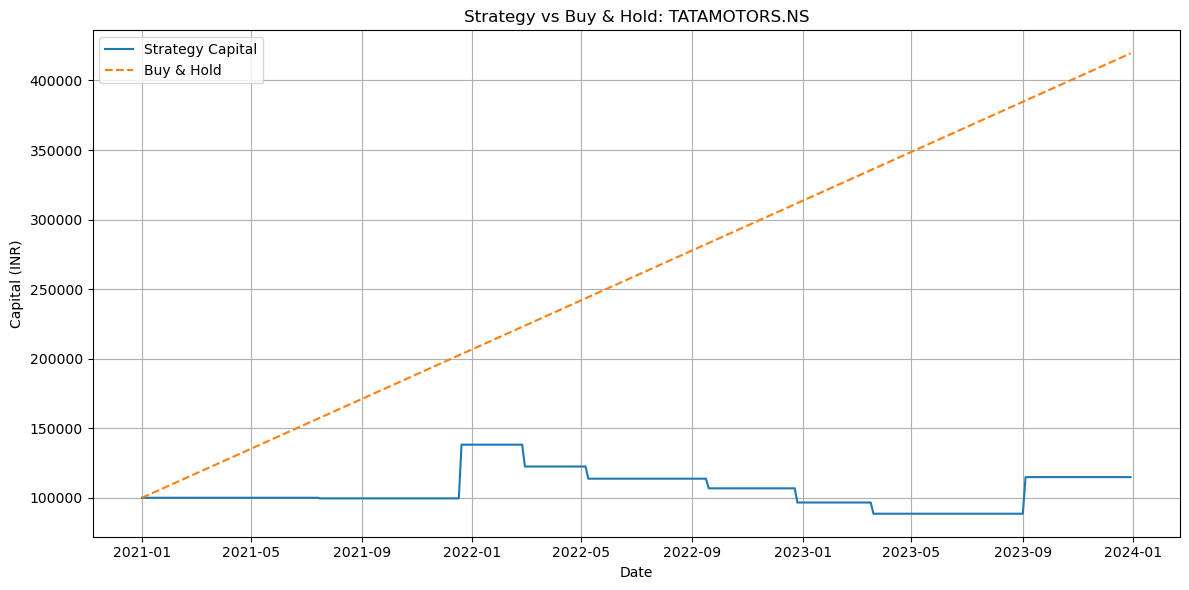

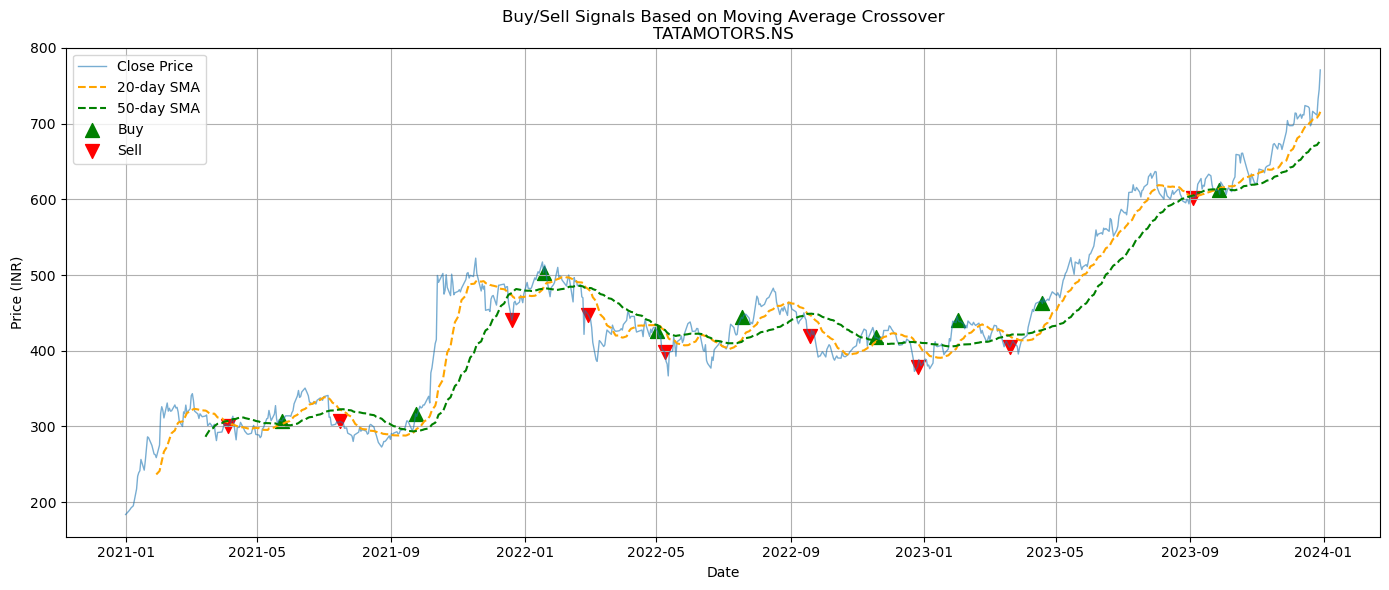

[*********************100%***********************]  1 of 1 completed


📄 Trade Log:
  Buy Date  Buy Price  Sell Date  Sell Price  Holding Days  Profit (₹)  Return (%)
2021-05-24     307.28 2021-07-16      306.69            53       -0.59       -0.19
2021-09-23     316.79 2021-12-20      440.50            88      123.71       39.05
2022-01-18     503.32 2022-02-28      447.40            41      -55.92      -11.11
2022-05-02     426.51 2022-05-09      398.03             7      -28.48       -6.68
2022-07-18     444.30 2022-09-19      419.22            63      -25.08       -5.64
2022-11-18     417.59 2022-12-26      379.16            38      -38.43       -9.20
2023-02-01     440.11 2023-03-20      404.73            47      -35.37       -8.04
2023-04-19     462.53 2023-09-04      601.95           138      139.43       30.14



/var/folders/tb/prkbktts03sc6mvrmc0sb9g80000gn/T/ipykernel_30294/2127621659.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  buy_signals.append((df.index[i], float(df['Close'].iloc[i])))
/var/folders/tb/prkbktts03sc6mvrmc0sb9g80000gn/T/ipykernel_30294/2127621659.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(df['Close'].iloc[i])



📊 SL/TP Strategy Report: TATAMOTORS.NS
💰 Final Capital: ₹118,462.80
📈 CAGR: 6.26%
📆 Avg Holding Period: 27.56 days
🔁 Trades Executed: 9
📉 Max Drawdown: ₹35,170.90 (27.27%)
📊 Sharpe Ratio: 0.428
📊 Sortino Ratio: 0.740
🏆 Win Rate: 44.44%


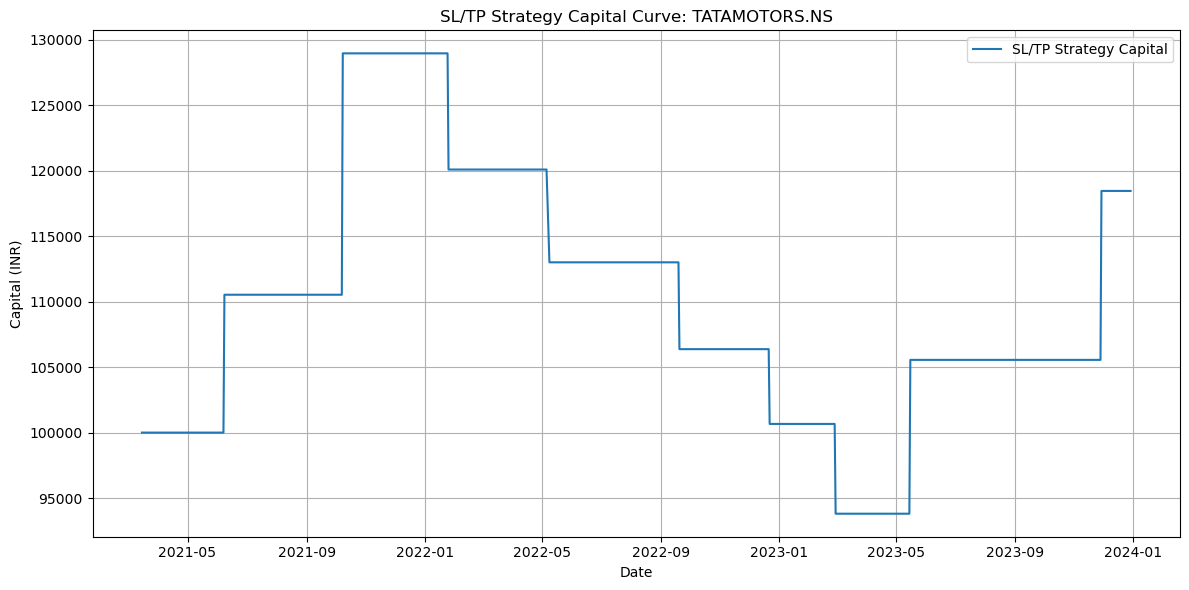

[*********************100%***********************]  1 of 1 completed
/var/folders/tb/prkbktts03sc6mvrmc0sb9g80000gn/T/ipykernel_30294/390724098.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  buy_signals.append((df.index[i], float(df['Close'].iloc[i])))
/var/folders/tb/prkbktts03sc6mvrmc0sb9g80000gn/T/ipykernel_30294/390724098.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(df['Close'].iloc[i])



📊 Trailing TP Strategy Report: TATAMOTORS.NS
💰 Final Capital: ₹154,850.63
📈 CAGR: 16.96%
🔁 Trades Executed: 9
📆 Avg Holding Period: 28.89 days
📉 Max Drawdown: ₹46,053.30 (27.17%)
📊 Sharpe Ratio: 0.585
📊 Sortino Ratio: 2.632
🏆 Win Rate: 44.44%


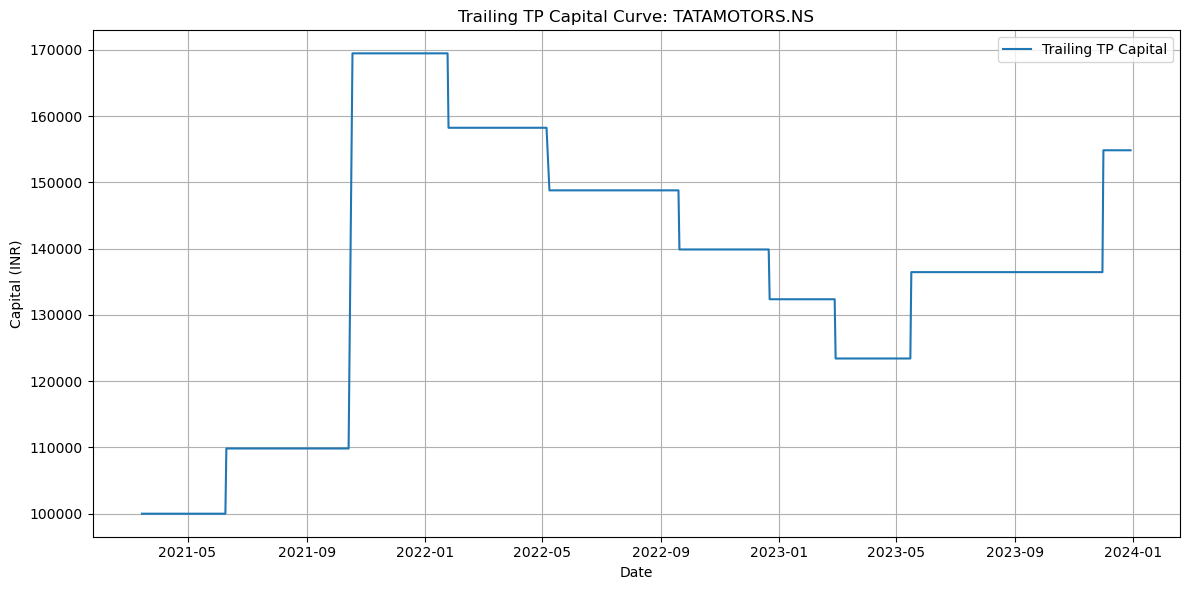

[*********************100%***********************]  1 of 1 completed
/var/folders/tb/prkbktts03sc6mvrmc0sb9g80000gn/T/ipykernel_30294/2411100060.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  buy_signals.append((df.index[i], float(df['Close'].iloc[i])))
/var/folders/tb/prkbktts03sc6mvrmc0sb9g80000gn/T/ipykernel_30294/2411100060.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  high = float(df['High'].iloc[j])
/var/folders/tb/prkbktts03sc6mvrmc0sb9g80000gn/T/ipykernel_30294/2411100060.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  low = float(df['Low'].iloc[j])


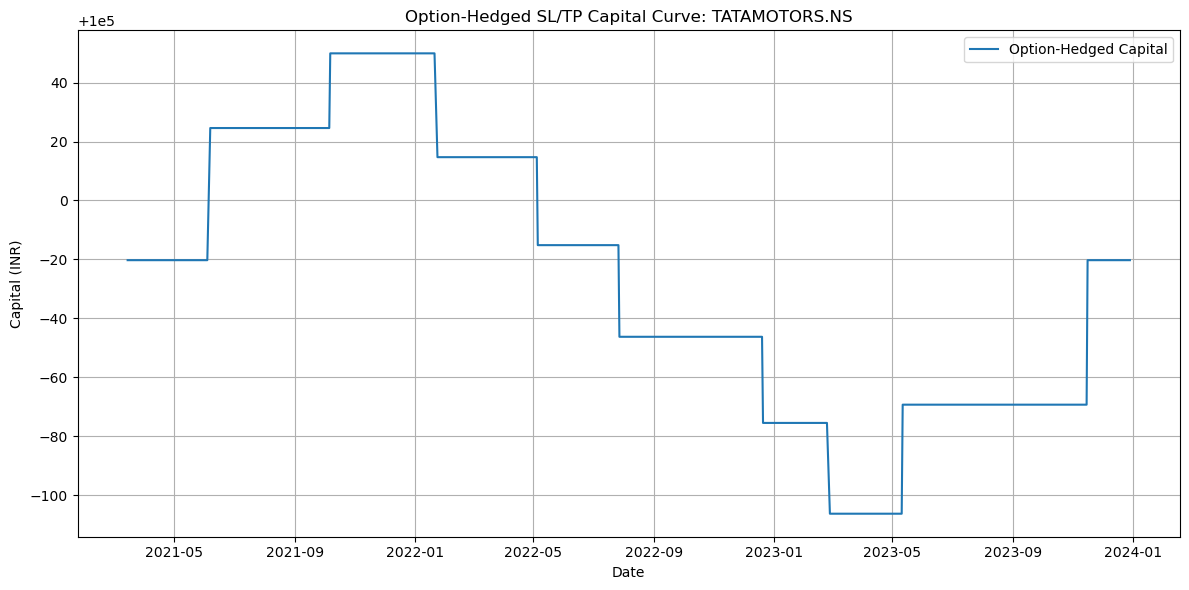


📊 Option-Hedged Strategy Report: TATAMOTORS.NS
💰 Final Capital: ₹99,979.74
📈 CAGR: -0.01%
🔁 Trades Executed: 9
📆 Avg Holding Period: 20.00 days
📉 Max Drawdown: ₹156.23 (0.16%)
📊 Sharpe Ratio: -0.710
📊 Sortino Ratio: -8525969506131753.000
🏆 Win Rate: 44.44%


In [140]:
a = run_backtest('TATAMOTORS.NS', '2021-01-01', '2024-01-01')
b = run_sl_tp_backtest('TATAMOTORS.NS', '2021-01-01', '2024-01-01')
c = run_trailing_tp_backtest('TATAMOTORS.NS', '2021-01-01', '2024-01-01')
d = run_option_hedge_backtest('TATAMOTORS.NS', '2021-01-01', '2024-01-01')